## 1) Завдання щодо генерації текстів на базі трансформера.

In [1]:
import os
import glob
import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from transformers import GPT2Config, GPT2LMHeadModel, GPT2TokenizerFast
from tokenizers import ByteLevelBPETokenizer

In [2]:
DATA_PATH = "lab4_datasets"
MODEL_SAVE_DIR = "lab4_model"
BATCH_SIZE = 8
BLOCK_SIZE = 128  # Довжина контексту (кількість токенів, яку бачить модель)
EPOCHS = 30
LEARNING_RATE = 5e-4

In [3]:
# функція для підготовки токенізатора
def train_tokenizer(files):
    # використовуємо ByteLevelBPE, який добре працює з Unicode (кирилицею)
    tokenizer = ByteLevelBPETokenizer()
    tokenizer.train(files=files, vocab_size=5000, min_frequency=2, special_tokens=[
        "<s>", "<pad>", "</s>", "<unk>", "<mask>"
    ])
    
    # зберігаємо токенізатор, щоб потім завантажити як GPT2Tokenizer
    if not os.path.exists(MODEL_SAVE_DIR):
        os.makedirs(MODEL_SAVE_DIR)
    tokenizer.save_model(MODEL_SAVE_DIR)
    
    # завантажуємо у форматі Transformers
    tokenizer_gpt = GPT2TokenizerFast.from_pretrained(MODEL_SAVE_DIR)
    tokenizer_gpt.add_special_tokens({
        "eos_token": "</s>",
        "bos_token": "<s>",
        "unk_token": "<unk>",
        "pad_token": "<pad>",
        "mask_token": "<mask>"
    })
    return tokenizer_gpt

In [4]:
class UkrainianTextDataset(Dataset):
    def __init__(self, files, tokenizer, block_size=128):
        self.examples = []
        text = ""
        # зчитуємо всі файли в один великий рядок
        for file_path in files:
            with open(file_path, "r", encoding="utf-8") as f:
                text += f.read() + "\n"
        
        # токенізуємо весь текст одразу
        tokenized_text = tokenizer.encode(text)
        
        # розбиваємо на шматки по block_size
        for i in range(0, len(tokenized_text) - block_size, block_size):
            self.examples.append(tokenized_text[i : i + block_size])

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, item):
        return torch.tensor(self.examples[item], dtype=torch.long)

In [5]:
class UkrainianGPT(pl.LightningModule):
    def __init__(self, vocab_size, lr=5e-4):
        super().__init__()
        self.save_hyperparameters()
        
        # створюємо конфігурацію маленького GPT-2
        config = GPT2Config(
            vocab_size=vocab_size,
            n_positions=512,
            n_ctx=512,
            n_embd=512, # розмірність вектора (embedding)
            n_layer=8, # кількість шарів трансформера
            n_head=8 # кількість attention heads
        )
        self.model = GPT2LMHeadModel(config)
        self.lr = lr

    def forward(self, input_ids, labels=None):
        return self.model(input_ids, labels=labels)

    def training_step(self, batch, batch_idx):
        outputs = self.model(batch, labels=batch)
        loss = outputs.loss
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters(), lr=self.lr)

In [6]:
files = glob.glob(f"{DATA_PATH}/*.txt")

In [7]:
# готуємо токенізатор
tokenizer = train_tokenizer(files)

In [8]:
# готуємо дані
dataset = UkrainianTextDataset(files, tokenizer, block_size=BLOCK_SIZE)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

In [9]:
# ініціалізуємо модель
model = UkrainianGPT(vocab_size=len(tokenizer), lr=LEARNING_RATE)

In [10]:
# налаштовуємо чекпоінт
checkpoint_callback = ModelCheckpoint(
    dirpath=MODEL_SAVE_DIR,
    filename="best-checkpoint",
    save_top_k=1,
    monitor="train_loss",
    mode="min"
)

In [13]:
trainer = pl.Trainer(
    max_epochs=EPOCHS,
    accelerator="auto",
    devices=1,
    callbacks=[checkpoint_callback],
    log_every_n_steps=3
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


In [14]:
trainer.fit(model, dataloader)

┏━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name  ┃ Type            ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model │ GPT2LMHeadModel │ 28.0 M │ train │     0 │
└───┴───────┴─────────────────┴────────┴───────┴───────┘

Trainable params: 28.0 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 28.0 M                                                                                               
Total estimated model params size (MB): 112                                                                        
Modules in train mode: 112                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=30` reached.


In [15]:
def generate_text(prompt_text, max_length=128):
    # перемикаємо модель в режим оцінки
    model.eval()
    
    # токенізуємо вхідний текст
    input_ids = tokenizer.encode(prompt_text, return_tensors="pt")
    
    input_ids = input_ids.to("mps")
    model.to("mps")

    # генерація
    
    with torch.no_grad():
        output_sequences = model.model.generate(
            input_ids=input_ids,
            max_length=max_length,
            num_return_sequences=1,
            no_repeat_ngram_size=2, # уникати повторення біграм
            repetition_penalty=1.5, # штраф за повтори слів
            temperature=0.7, # температура
            do_sample=True,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )

    # декодування результату
    generated_text = tokenizer.decode(output_sequences[0], skip_special_tokens=True)
    print(generated_text)

In [17]:
generate_text("Григорій Сковорода")

Григорій Сковорода, Касм 141—17635. Весильницький Варлаам 350, 464 «Слов» 67, 497
   Стефан 79 Густавович (1849) — ?) український історик і педагог ліберально-буржуазного напряму; теорії українських патріартин зокретикантичного просмаційного видатаного близько 222 р., 926 рр. Від його драми серіологів української культури незначувалася тою рукою французефями Свана Дніка* та ЖИсторична праця в Ю


In [19]:
generate_text("Читаючи оцю транскрипцію")

Читаючи оцю транскрипцію й обов’єсиру Ісулістю раносити докупи багатьох генералного духу. Та, що такі дали нам усну святу; з них людей мим більше їх повідності та гризоти Шевченка на весь світ забуває нас підкладатися в завдяки гаряцтва лишається для більших і мічах зачитувати йому перспекції народів,— сказав би їй було до такого життя осотної релігії або тратитітування виділу зробиться вона не може бути перемінвати тільки де


In [20]:
generate_text("велика сила рукописного матеріалу лежить не опублікована")

велика сила рукописного матеріалу лежить не опублікована, що трактом користувався книжками в різних часах. Аж коли вірші при наголочилися на початку мартаськім тексти з початком XVIII ст., отже, сто літ і перейшла ще таке або спроможне світло про якусь ясну дену1 її генеракуцію можна би вважати віршовані старшість як Шумлянського; вона чи літературна українська мова знаходиться діється лучні свої великоруську мову. Важається й теки, без сумніву такого часу були верховили постатього дяківіисувати


## 2) Завдання щодо генерації зображень

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl
from pytorch_lightning.callbacks import Callback
import matplotlib.pyplot as plt
import numpy as np

In [22]:
BATCH_SIZE = 128
LR = 0.0001
Z_DIM = 100        # розмір вектора шуму
CHANNELS_IMG = 1   # 1 для FashionMNIST (ч/б)
IMAGE_SIZE = 64
EPOCHS = 20

In [23]:
class Generator(nn.Module):
    def __init__(self, z_dim, channels_img):
        super().__init__()
        self.gen = nn.Sequential(
            # Вхід: N x z_dim x 1 x 1
            self._block(z_dim, 512, 4, 1, 0),      # -> 4x4
            self._block(512, 256, 4, 2, 1),        # -> 8x8
            self._block(256, 128, 4, 2, 1),        # -> 16x16
            self._block(128, 64, 4, 2, 1),         # -> 32x32
            nn.ConvTranspose2d(64, channels_img, 4, 2, 1), # -> 64x64
            nn.Tanh(), # Вихід [-1, 1]
        )

    def _block(self, in_channels, out_channels, kernel, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True),
        )

    def forward(self, x):
        return self.gen(x)

In [24]:
class Discriminator(nn.Module):
    def __init__(self, channels_img):
        super().__init__()
        self.disc = nn.Sequential(
            # вхід: N x channels_img x 64 x 64
            nn.Conv2d(channels_img, 64, 4, 2, 1),  # -> 32x32
            nn.LeakyReLU(0.2, inplace=True),
            self._block(64, 128, 4, 2, 1),         # -> 16x16
            self._block(128, 256, 4, 2, 1),        # -> 8x8
            self._block(256, 512, 4, 2, 1),        # -> 4x4
            nn.Conv2d(512, 1, 4, 1, 0),            # -> 1x1
            nn.Sigmoid(),
        )

    def _block(self, in_channels, out_channels, kernel, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        return self.disc(x)

In [25]:
class DCGAN(pl.LightningModule):
    def __init__(self, channels_img=CHANNELS_IMG, z_dim=Z_DIM, lr=LR):
        super().__init__()
        self.save_hyperparameters()
        
        # ініціалізація моделей
        self.generator = Generator(z_dim, channels_img)
        self.discriminator = Discriminator(channels_img)
        
        # ініціалізація ваг для стабільності GAN
        self.generator.apply(self._weights_init)
        self.discriminator.apply(self._weights_init)

        self.criterion = nn.BCELoss()
        
        # фіксований шум для валідації (щоб бачити прогрес на одних і тих же векторах)
        self.validation_z = torch.randn(32, z_dim, 1, 1)

        self.automatic_optimization = False

    def forward(self, z):
        return self.generator(z)

    def _weights_init(self, m):
        classname = m.__class__.__name__
        if 'Conv' in classname:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif 'BatchNorm' in classname:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)

    def configure_optimizers(self):
        lr = self.hparams.lr
        opt_g = optim.Adam(self.generator.parameters(), lr=lr, betas=(0.5, 0.999))
        opt_d = optim.Adam(self.discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
        return [opt_g, opt_d], []

    def training_step(self, batch, batch_idx):
        # отримуємо оптимізатори
        opt_g, opt_d = self.optimizers()
        
        real_imgs, _ = batch
        batch_size = real_imgs.size(0)
        
        # створюємо мітки (1 - real, 0 - fake)
        real_label = torch.ones(batch_size, device=self.device)
        fake_label = torch.zeros(batch_size, device=self.device)
        
        # генеруємо шум
        z = torch.randn(batch_size, self.hparams.z_dim, 1, 1, device=self.device)

        # навчання на реальних фото
        output_real = self.discriminator(real_imgs).view(-1)
        loss_real = self.criterion(output_real, real_label)
        
        # навчання на фейкових фото
        fake_imgs = self.generator(z)
        output_fake = self.discriminator(fake_imgs.detach()).view(-1)
        loss_fake = self.criterion(output_fake, fake_label)
        
        loss_d = (loss_real + loss_fake) / 2
        
        # крок оптимізації D
        opt_d.zero_grad()
        self.manual_backward(loss_d)
        opt_d.step()

        # ми хочемо обдурити дискримінатор, щоб він сказав "1" (real)
        output_fake_for_g = self.discriminator(fake_imgs).view(-1)
        loss_g = self.criterion(output_fake_for_g, real_label)
        
        # крок оптимізації G
        opt_g.zero_grad()
        self.manual_backward(loss_g)
        opt_g.step()

        # логування
        self.log_dict({"g_loss": loss_g, "d_loss": loss_d}, prog_bar=True)

In [26]:
class ImageLogCallback(Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        # кожну епоху генеруємо картинки з фіксованого шуму
        with torch.no_grad():
            pl_module.eval()
            z = pl_module.validation_z.to(pl_module.device)
            images = pl_module(z)
            pl_module.train()
            
            # денормалізація та збереження
            grid = torchvision.utils.make_grid(images, normalize=True)
            grid = grid.permute(1, 2, 0).cpu().numpy()
            
            plt.figure(figsize=(6, 6))
            plt.imshow(grid)
            plt.title(f"Epoch {trainer.current_epoch}")
            plt.axis('off')
            plt.show()

In [27]:
# підготовка даних
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])

In [28]:
dataset = torchvision.datasets.FashionMNIST(root="./data", train=True, 
                                          transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=7)

  0%|                                               | 0.00/26.4M [00:00<?, ?B/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██████████████████████████████████████| 26.4M/26.4M [00:03<00:00, 6.90MB/s]
100%|███████████████████████████████████████| 29.5k/29.5k [00:00<00:00, 325kB/s]
100%|██████████████████████████████████████| 4.42M/4.42M [00:01<00:00, 3.75MB/s]
100%|██████████████████████████████████████| 5.15k/5.15k [00:00<00:00, 2.38MB/s]


In [29]:
model = DCGAN()

In [30]:
trainer = pl.Trainer(
    max_epochs=EPOCHS,
    accelerator="auto",
    devices=1,
    callbacks=[ImageLogCallback()] # додаємо наш callback для картинок
)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type          ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ generator     │ Generator     │  3.6 M │ train │     0 │
│ 1 │ discriminator │ Discriminator │  2.8 M │ train │     0 │
│ 2 │ criterion     │ BCELoss       │      0 │ train │     0 │
└───┴───────────────┴───────────────┴────────┴───────┴───────┘

Trainable params: 6.3 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 6.3 M                                                                                                
Total estimated model params size (MB): 25                                                                         
Modules in train mode: 39                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:429: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been u

Output()

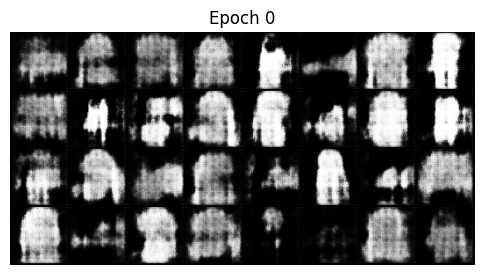

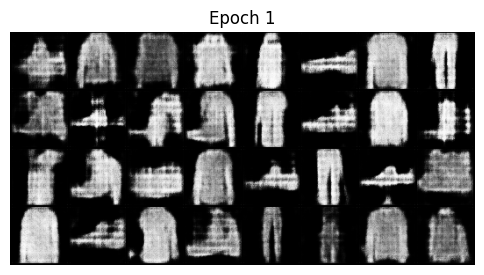

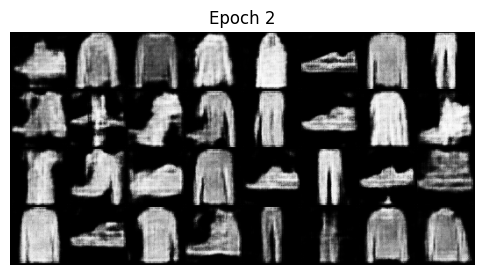

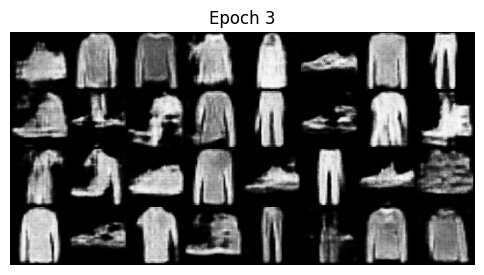

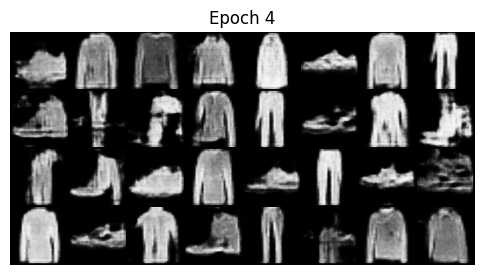

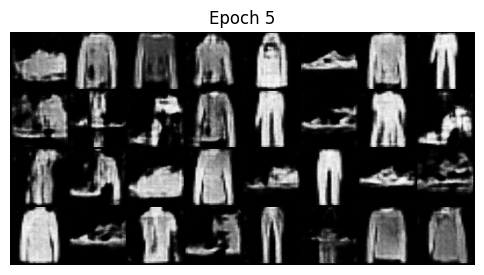

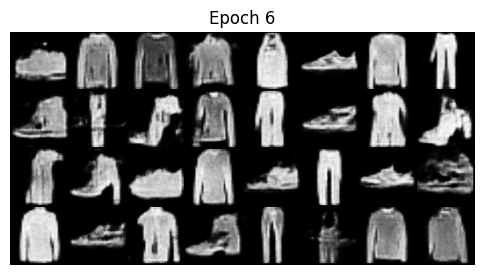

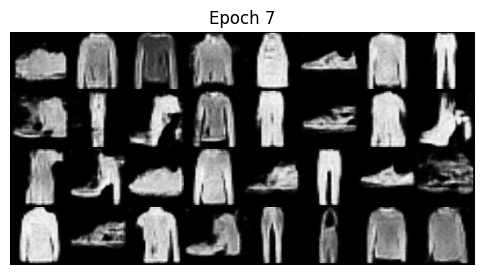

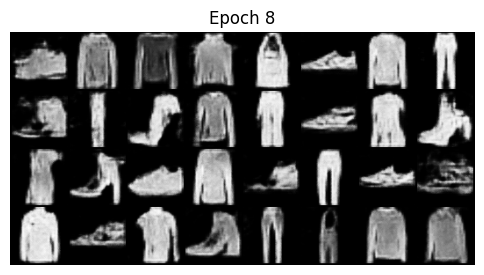

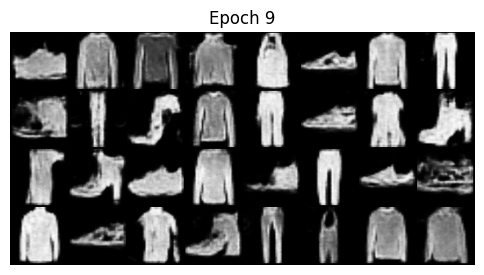

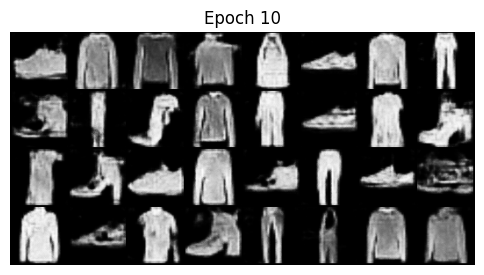

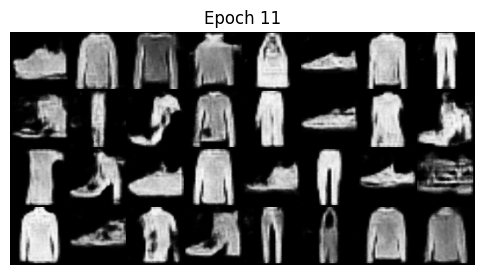

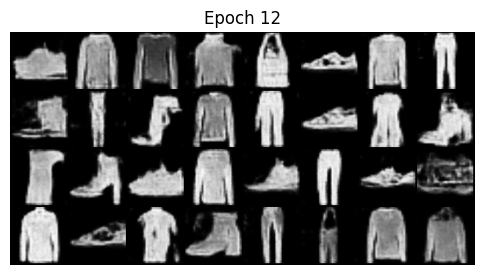

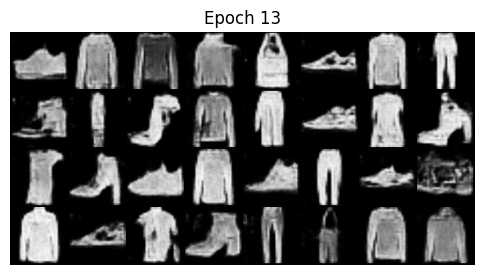

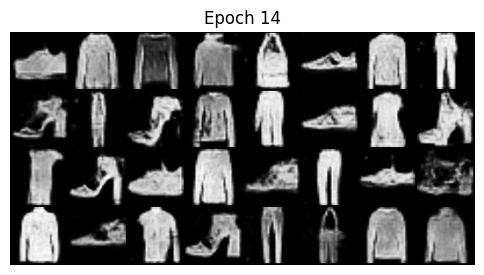

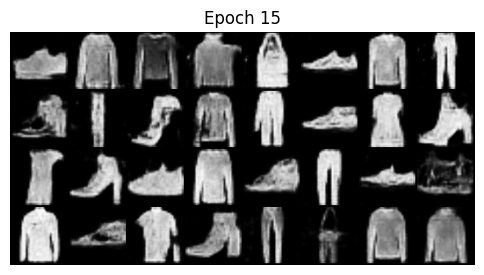

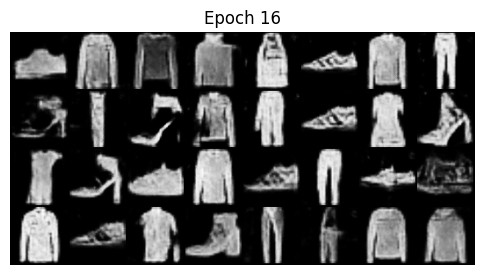

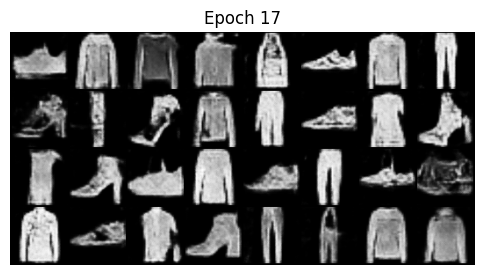

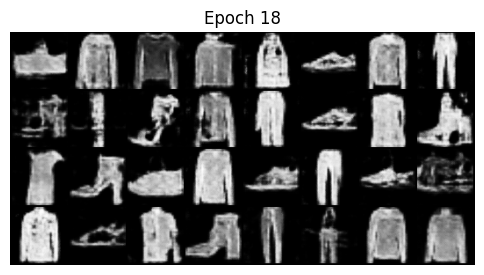

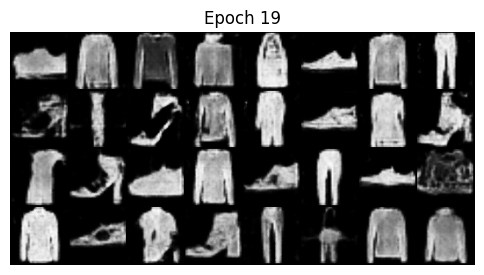

`Trainer.fit` stopped: `max_epochs=20` reached.


In [31]:
trainer.fit(model, dataloader)

## 3) Проведіть експерименти з моделями бібліотеки Hugging Face

### a) Візьміть свій датасет для класифікації текстів

In [32]:
import pandas as pd
import numpy as np

In [33]:
sentiment_df = pd.read_csv("tweets.csv")

In [34]:
sentiment_df = sentiment_df[["airline_sentiment", "text"]]

In [35]:
import nltk
from nltk.corpus import stopwords


nltk.download("stopwords", quiet=True)

True

In [36]:
import re

In [37]:
stop_words = set(stopwords.words("english"))

def clean_text(text):
    # приведення до нижнього регістру
    text = text.lower()
    # видалення згадок користувачів (@user)
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    # видалення символів, що не є словами (пунктуація, цифри)
    text = re.sub(r'[^a-z\s]', '', text)
    # видалення зайвих пробілів
    text = re.sub(r'\s+', ' ', text).strip()
    # видалення стоп-слів
    words = text.split()
    filtered_words = [w for w in words if w not in stop_words and len(w) > 2]
    return " ".join(filtered_words)

# застосовуємо очищення
sentiment_df["clean_text"] = sentiment_df["text"].apply(clean_text)

In [38]:
sentiment_df

,airline_sentiment,text,clean_text
0,neutral,@VirginAmerica What @dhepburn said.,said
1,positive,@VirginAmerica plus you've added commercials t...,plus youve added commercials experience tacky
2,neutral,@VirginAmerica I didn't today... Must mean I n...,didnt today must mean need take another trip
3,negative,@VirginAmerica it's really aggressive to blast...,really aggressive blast obnoxious entertainmen...
4,negative,@VirginAmerica and it's a really big bad thing...,really big bad thing
...,...,...,...
14635,positive,@AmericanAir thank you we got on a different f...,thank got different flight chicago
14636,negative,@AmericanAir leaving over 20 minutes Late Flig...,leaving minutes late flight warnings communica...
14637,neutral,@AmericanAir Please bring American Airlines to...,please bring american airlines blackberry
14638,negative,"@AmericanAir you have my money, you change my ...",money change flight dont answer phones suggest...


In [2]:
import pandas as pd
from transformers import pipeline
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm

In [43]:
pipe_1 = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment-latest")

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use mps:0


In [60]:
preds_1 = []
for text in sentiment_df['clean_text'][:5000]:
    res = pipe_1(text, truncation=True, max_length=512)
    label = res[0]['label']
    if label == 'positive':
        preds_1.append('positive')
    elif label == 'neutral':
        preds_1.append('neutral')
    else:
        preds_1.append('negative')

In [61]:
pipe_2 = pipeline("sentiment-analysis", model="finiteautomata/bertweet-base-sentiment-analysis")

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Device set to use mps:0


In [66]:
preds_2 = []
for text in sentiment_df['clean_text'][:5000]:
    res = pipe_2(text, truncation=True, max_length=512)
    label = res[0]['label']
    if label == 'POS':
        preds_2.append('positive')
    elif label == 'NEU':
        preds_2.append('neutral')
    else:
        preds_2.append('negative')

In [67]:
print("Результати першої моделі: twitter-roberta-base-sentiment")
print("Accuracy:", accuracy_score(sentiment_df['airline_sentiment'][:5000], preds_1))
print(classification_report(sentiment_df['airline_sentiment'][:5000], preds_1))

print("\n\nРезультати другої моделі: bertweet-base-sentiment-analysis")
print("Accuracy:", accuracy_score(sentiment_df['airline_sentiment'][:5000], preds_2))
print(classification_report(sentiment_df['airline_sentiment'][:5000], preds_2))

Результати першої моделі: twitter-roberta-base-sentiment
Accuracy: 0.661
              precision    recall  f1-score   support

    negative       0.92      0.61      0.73      3130
     neutral       0.39      0.74      0.51      1057
    positive       0.66      0.74      0.70       813

    accuracy                           0.66      5000
   macro avg       0.66      0.70      0.65      5000
weighted avg       0.76      0.66      0.68      5000



Результати другої моделі: bertweet-base-sentiment-analysis
Accuracy: 0.6578
              precision    recall  f1-score   support

    negative       0.92      0.62      0.74      3130
     neutral       0.39      0.76      0.52      1057
    positive       0.65      0.67      0.66       813

    accuracy                           0.66      5000
   macro avg       0.65      0.68      0.64      5000
weighted avg       0.76      0.66      0.68      5000



Власна модель продемонструвала значно кращу якість класифікації (accuracy 0.79) порівняно з претренованими трансформерами, які показали результат на рівні 0.66. Це пояснюється тим, що моя модель навчалася безпосередньо на цільовому датасеті і змогла адаптуватися до специфіки відгуків про авіалінії, досягнувши високого F1-score (0.87) для домінуючого негативного класу, тоді як універсальні моделі (twitter-roberta та bertweet) без файн-тюнингу помилялися частіше, особливо плутаючи нейтральні коментарі (precision 0.39) та пропускаючи значну частину негативу (recall 0.61-0.62).

### b) Знайдіть українські мовні моделі, наведіть приклади роботи з ними (через pipeline) на завданнях (zero-shot-classification, summarization, translation)

In [3]:
translator = pipeline("translation", model="Helsinki-NLP/opus-mt-uk-en")

Exception ignored in: <function tqdm.__del__ at 0x109bb6160>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm' object has no attribute 'disp'
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
Device set to use mps:0


In [4]:
text_uk = "Штучний інтелект стрімко розвивається і змінює світ."

result_trans = translator(text_uk)
print(f"Original: {text_uk}")
print(f"Translated: {result_trans[0]['translation_text']}")

Original: Штучний інтелект стрімко розвивається і змінює світ.
Translated: The artificial intelligence is rapidly developing and changing the world.


In [6]:
classifier = pipeline("zero-shot-classification", model="MoritzLaurer/mDeBERTa-v3-base-mnli-xnli")

Device set to use mps:0


In [7]:
sequence_to_classify = "Я люблю борщ з пампушками."
candidate_labels = ["політика", "їжа", "технології"]

result_zero = classifier(sequence_to_classify, candidate_labels)
print(f"Text: {sequence_to_classify}")
print(f"Top Label: {result_zero['labels'][0]} (Score: {result_zero['scores'][0]:.2f})")

Text: Я люблю борщ з пампушками.
Top Label: їжа (Score: 0.99)


In [10]:
summarizer = pipeline("summarization", model="lljllll2219/uk-mt5-base-xlsum-v2")

Device set to use mps:0
Exception ignored in: <function tqdm.__del__ at 0x109bb6160>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm' object has no attribute 'disp'


In [11]:
long_text = "Борщ — українська рідка страва, що вариться з посічених буряків, капусти з додаванням картоплі, квасолі, та різних приправ. Збірна назва різних варіантів першої страви, спільною особливістю яких, ймовірно, є кислуватий, квасний смак. Найчастіше під словом «борщ» розуміють якраз черво́ний борщ. Є основною першою стравою української кухні. Він набув міжнародне визнання. Український борщ — національна страва українців, символ української кулінарної культури і достатку."

result_sum = summarizer(long_text, max_length=30, clean_up_tokenization_spaces=True)
print(f"Summary: {result_sum[0]['summary_text']}")

Both `max_new_tokens` (=256) and `max_length`(=30) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Summary: Український борщ - основна перша страва української кухні
